In [1]:
import os
import hashlib
import shutil

In [2]:
!unzip wound_dataset.zip

Archive:  wound_dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of wound_dataset.zip or
        wound_dataset.zip.zip, and cannot find wound_dataset.zip.ZIP, period.


In [3]:
# --- Data Understanding ---

# Check length of each label
import os
path='/content/wound_dataset'
dataset_dir = os.listdir(path)

total_data = 0 #save total data
for i in dataset_dir:
  label_dir = os.path.join(path, i)
  if os.path.isdir(label_dir):
    files = os.listdir(label_dir)
    num_files = len(files)
    total_data += num_files #add number of data to total_data

    a='{} label has a total of '.format(i).ljust(50)
    a+= ' : '
    print(a, num_files, ' images')
  else:
    print('\nPath {} is not a directory.\n'.format(label_dir))

#after looping is done, print the result
print("\nTotal data across all labels:", total_data)


#Recursively delete all .DS_Store files from the given directory and its subdirectories
def delete_ds_store(path):
  for root, dirs, files in os.walk(path):
    for file in files:
      if file == ".DS_Store":
        os.remove(os.path.join(root, file))
        print(f"Deleted .DS_Store file: {os.path.join(root, file)}")


Burns label has a total of                         :  480  images
Abrasions label has a total of                     :  480  images
Bruises label has a total of                       :  481  images

Total data across all labels: 1441


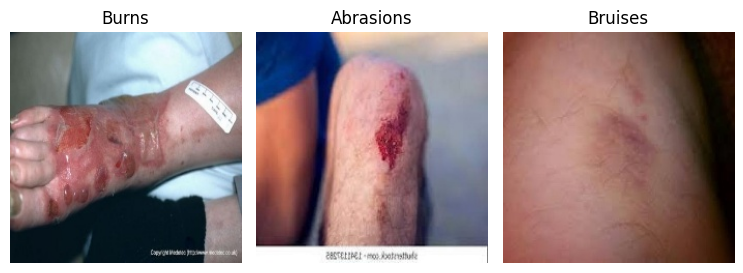

In [4]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import matplotlib.image as mping
import random
from math import ceil

#create figure
fig = plt.figure(figsize=(10, 10))

#loop through each of the label directories
for i in range(len(dataset_dir)):
    #get the label name
    label_name = dataset_dir[i]

    #create the full path to the label directory
    label_dir = os.path.join(path, label_name)

    #check if the current item in the loop is a directory
    if os.path.isdir(label_dir):
        #open the label directory
        images = os.listdir(label_dir)

        #pick a random image from the directory
        random_image = random.choice(images)

        #create the full path to the random image
        random_image_path = os.path.join(label_dir, random_image)

        #read the image
        img = mping.imread(random_image_path)

        #plot the image
        plt.subplot(ceil(len(dataset_dir)/4), 4, i+1)
        plt.title(label_name)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

#show all plots
plt.tight_layout()
plt.show()

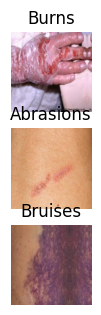

In [5]:
# --- show image ---
cols = 4
rows = ceil(len(dataset_dir) / cols)

x = 0
for i in dataset_dir:
    label_dir = os.path.join(path, i)

    if os.path.isdir(label_dir):
        files = os.listdir(label_dir)

        # pick random image
        rnd = random.choice(files)

        imgg = os.path.join(label_dir, rnd)
        Image = mping.imread(imgg)

        plt.subplot(cols, rows, x+1)
        plt.imshow(Image)
        plt.title(i)

        plt.axis('off')
        x += 1

    else:
        print("Skipping non-directory file:", label_dir)

# --- DATA PREPROCESSING ---

In [6]:
"""Remove duplicate images from each label"""

!pip install Pillow
import hashlib
from matplotlib.pyplot import imread

import imageio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import shutil

"""Define the functions"""
def find_duplicates(col_name):
    os.chdir(col_name)
    os.getcwd()
    files_list = os.listdir('.')

    print("Number of files in the current directory:", len(files_list))

    duplicates = []
    hash_keys = dict()
    for index, filename in enumerate(os.listdir('.')):
        if os.path.isfile(filename):
            with open(filename, 'rb') as f:
                filehash = hashlib.md5(f.read()).hexdigest()
            if filehash not in hash_keys:

                hash_keys[filehash] = index
            else:
                duplicates.append((index, hash_keys[filehash]))


    if not duplicates:
        print('Result of Duplicates: 0')
    else:
        duplicates.sort(key=lambda x: x[1])
        print('Result of Duplicates:', duplicates)
    return duplicates, files_list

In [7]:
# Define a function to move files to a new directory
def move_dups_to_new_dir(source_dir, destination_dir, dup_indexes, files_list):
  for index in dup_indexes:
    source_file = files_list[index]
    destination_file = os.path.join(destination_dir, os.path.basename(source_file))
    shutil.move(source_file, destination_file)

In [8]:
"Checking and Moving The Duplicates"
path='/content/wound_dataset'

duplicate_dir = '/content/DuplicateFiles'

# Loop through all directories in the path
for col_name in os.listdir(path):
  col_path= os.path.join(path, col_name)
  if os.path.isdir(os.path.join(path, col_name)):
    print(f"Checking duplicates in {col_path}")
    result = find_duplicates(col_path)
    if result is not None:
      duplicates, files_list = result
      os.makedirs(duplicate_dir, exist_ok=True) # Create the duplicate directory if it doesn't exist

      # Showing result of duplicates
      for file_indexes in duplicates[:30]:
        try:
          file_index_0, file_index_1 = file_indexes
          if file_index_0 < len(files_list) and file_index_1 < len(files_list):
            plt.subplot(121), plt.imshow(imread(files_list[file_index_1]))
            plt.title('index {}'.format(file_index_1)), plt.xticks([]), plt.yticks([])

            plt.subplot(122), plt.imshow(imread(files_list[file_index_0]))
            plt.title('index {} is the duplicate'.format(file_index_0)), plt.xticks([]), plt.yticks([])

            plt.show()
        except OSError as e:
          continue

Checking duplicates in /content/wound_dataset/Burns
Number of files in the current directory: 480
Result of Duplicates: 0
Checking duplicates in /content/wound_dataset/Abrasions
Number of files in the current directory: 480
Result of Duplicates: 0
Checking duplicates in /content/wound_dataset/Bruises
Number of files in the current directory: 481
Result of Duplicates: 0


In [9]:
"""SMOTE for imbalanced dataset"""
import pandas as pd
from skimage.transform import resize
from skimage.io import imread
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter

Categories_1 = os.listdir(path)

flat_data_arr_1 = []
target_arr_1 = []
for i in Categories_1:

    print(f'loading... category: {i}')
    path1 = os.path.join(path, i)
    for img in os.listdir(path1):
        if img != '.DS_Store':
            img_array = imread(os.path.join(path1, img))
            img_resized = resize(img_array, (150, 150, 3))
            flat_data_arr_1.append(img_resized.flatten())
            target_arr_1.append(Categories_1.index(i))
    print(f'loaded category: {i} successfully')

flat_data_1 = np.array(flat_data_arr_1)
target = np.array(target_arr_1)

df_1 = pd.DataFrame(flat_data_1)
df_1['Target'] = target

x_1 = df_1.iloc[:, :-1]
y_1 = df_1.iloc[:, -1]

y_1 = LabelEncoder().fit_transform(y_1)

# Terapkan SMOTE
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_1, y_1)

# Cek jumlah data sebelum dan sesudah SMOTE
print("Sebelum SMOTE:", Counter(y_1))
print("Setelah SMOTE:", Counter(y_smote))

loading... category: Burns
loaded category: Burns successfully
loading... category: Abrasions
loaded category: Abrasions successfully
loading... category: Bruises
loaded category: Bruises successfully
Sebelum SMOTE: Counter({2: 481, 0: 480, 1: 480})
Setelah SMOTE: Counter({0: 481, 1: 481, 2: 481})


# OVERSAMPLING

In [10]:
# --- Oversampling Methode ---
from imblearn.over_sampling import SMOTE
from collections import Counter

oversample_1 = SMOTE()
x_1, y_1 = oversample_1.fit_resample(x_1, y_1)

# summarize the new class distribution
counter = Counter(y_1)
print(counter)

Counter({0: 481, 1: 481, 2: 481})


In [11]:
# --- Transforming into pictures again ---
# Create new dir for dataset after being resampled
import os
from PIL import Image
import numpy as np

new_dir = '/content/new_dataset_after_resampling'
os.makedirs(new_dir, exist_ok=True)  # Use makedirs with exist_ok to avoid errors if directory exists

for i in range(len(x_1)):  # Loop through the indices of x_1
    # Check if directory exists and create it if needed
    if not os.path.isdir(os.path.join(new_dir, Categories_1[y_1[i]])):
        os.makedirs(os.path.join(new_dir, Categories_1[y_1[i]]), exist_ok=True)

    # Define image name and path
    name_dir = os.path.join(new_dir, Categories_1[y_1[i]])
    a = np.array(x_1.iloc[i]).reshape(150, 150, 3)
    img = Image.fromarray((a * 255).astype(np.uint8))
    img.save(os.path.join(name_dir, Categories_1[y_1[i]] + '_{}.png'.format(i)))


In [12]:
# --- Menghitung jumlah data ---
dataset_dir = os.listdir(new_dir)
total_data = 0  # Inisialisasi variabel untuk menyimpan total data

for label in dataset_dir:  # Iterate through label directory names
    label_dir = os.path.join(new_dir, label)
    if os.path.isdir(label_dir):
        files = os.listdir(label_dir)
        num_files = len(files)
        total_data += num_files  # Add the number of label data to total_data

        a = '{} label has a total of '.format(label).ljust(50)
        a += ': '
        print(a, num_files, 'images')
    else:
        print('\nPath {} is not a directory.\n'.format(label_dir))

# After the loop is finished, print the total overall data
print("\nTotal data across all labels:", total_data)

Burns label has a total of                        :  481 images
Abrasions label has a total of                    :  481 images
Bruises label has a total of                      :  481 images

Total data across all labels: 1443


# AUGMENTASI

In [13]:
# --- Augmentation Data ---
!pip install split-folders
import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
# --- Augmentation Parameters ---
BATCH_SIZE = 16
TARGET_SIZE = 150
AUGMENTATION_FACTOR = 8  # Number of augmentations

dataset_dir = '/content/new_dataset_after_resampling'
output_dir = '/content/Dataset_split'

In [15]:
# --- Splitting Dataset ---
splitfolders.ratio(dataset_dir, output=output_dir, seed=42,
                   ratio=(0.8, 0.2), group_prefix=None)

train_dir = '/content/Dataset_split/train'
val_dir = '/content/Dataset_split/val'

Copying files: 1443 files [00:00, 4850.12 files/s]


In [16]:
# --- Create new dir for final augmented dataset ---
augmented_train_dir = '/content/Dataset_split/train_augmented'
os.makedirs(augmented_train_dir, exist_ok=True)

# --- Create subdir in augmented_train_dir (for classes) ---
class_names = os.listdir(dataset_dir)

for class_name in class_names:
    class_augmented_dir = os.path.join(augmented_train_dir, class_name)
    os.makedirs(class_augmented_dir, exist_ok=True)

# --- Calling classes function ---
def get_class_name_from_image(image_path):
    """
    Ambil nama direktori terakhir dari path gambar sebagai nama kelas
    """
    class_name = os.path.basename(os.path.dirname(image_path))
    return class_name

# --- Inisialitation Augmentation Generator ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.4,
    zoom_range=0.4,
    rotation_range=40,
    horizontal_flip=True,
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [17]:
# --- Augmentation Process ---
for root, _, files in os.walk(train_dir):
    for file in files:
        image_path = os.path.join(root, file)
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(TARGET_SIZE, TARGET_SIZE))
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        class_name = get_class_name_from_image(image_path)
        class_augmented_dir = os.path.join(augmented_train_dir, class_name)
        os.makedirs(class_augmented_dir, exist_ok=True)
        for batch in train_datagen.flow(x, batch_size=1):
            augmented_image = tf.keras.preprocessing.image.array_to_img(batch[0])
            augmented_image.save(os.path.join(class_augmented_dir, f'augmented_{i}.png'))
            i += 1
            if i >= AUGMENTATION_FACTOR:
                break

In [18]:
"""Evaluation of The Augmentation Results"""
# Checking PSNR
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import io, color

import shutil

# Dir inisialitation
original_images_dir = "/content/Dataset_split/train"
augmented_images_dir = "/content/Dataset_split/train_augmented"
output_dir = "/content/resoluted_dataset"  # output dir to save imgs

os.makedirs(output_dir, exist_ok=True)

In [19]:
# Looping each subdir classes
class_names = os.listdir(augmented_images_dir)  # Use train_augmented dir
for class_name in class_names:
    class_original_dir = os.path.join(original_images_dir, class_name)
    class_augmented_dir = os.path.join(augmented_images_dir, class_name)

    # Variables inisialitation for current class
    total_psnr = 0
    count = 0

    original_images = os.listdir(class_original_dir)

    # Looping imgs in class subdir
    for image_name in original_images:
        original_image_path = os.path.join(class_original_dir, image_name)
        original_image = io.imread(original_image_path)

        # Making sure the images are in grayscale mode
        original_image = color.rgb2gray(original_image)

In [20]:
for augmented_image_name in os.listdir(class_augmented_dir):
    augmented_image_path = os.path.join(class_augmented_dir, augmented_image_name)
    augmented_image = io.imread(augmented_image_path)

    # Making sure the images are in grayscale mode
    augmented_image = color.rgb2gray(augmented_image)

    # psnr score
    psnr_score = psnr(original_image, augmented_image)

    # If PSNR score > 11..., copy the imgs to resolute_dataset
    if psnr_score > 11.992841544610027:
        target_dir = os.path.join(output_dir, class_name)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(augmented_image_path, target_dir)

    total_psnr += psnr_score
    count += 1

In [21]:
# Calculating PSNR means for current class
average_psnr = total_psnr / count

# Tampilkan rata-rata PSNR untuk kelas saat ini
print(f"Class: {class_name}, Average PSNR Score: {average_psnr}")

train_final = '/content/new_dataset_after_resampling'

Class: Bruises, Average PSNR Score: 8.711210190913468


In [22]:
# Generator for augmented dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_final,
    target_size=(TARGET_SIZE, TARGET_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(TARGET_SIZE,TARGET_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)

Found 1443 images belonging to 3 classes.
Found 425 images belonging to 3 classes.


In [23]:
"Checking Data After Augmented"
# Checking the length of resoluted_dataset_dir
resoluted_dataset_dir = "/content/resoluted_dataset"

# Dictionary inisialitation to save data of each class
class_counts = {}

Class: Bruises, Count: 8
Total Data: 8


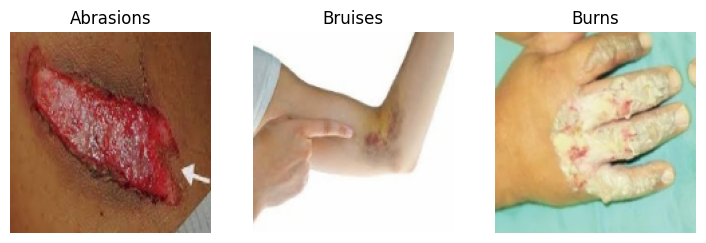

In [24]:
# --- Checking Data After Augmented ---
# Looping through each subdir
class_names = os.listdir(resoluted_dataset_dir)

total_data = 0
# Class_counts = {}  # Inisialisasi dictionary untuk menyimpan total data

for class_name in class_names:
    class_dir = os.path.join(resoluted_dataset_dir, class_name)
    class_count = len(os.listdir(class_dir))  # Menghitung jumlah data
    class_counts[class_name] = class_count  # Menyimpan jumlah data ke dictionary

    total_data += class_count  # Menambahkan jumlah data ke total_data

# Menampilkan jumlah data di setiap kelas
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")

# Menampilkan jumlah total data
print("Total Data:", total_data)

"Result of Augmentations"
result = sorted(os.listdir(train_final))

plt.figure(figsize=(12, 12))

for i, class_name in enumerate(result):
    class_augmented_dir = os.path.join(train_final, class_name)
    files = os.listdir(class_augmented_dir)  # Mengambil satu gambar hasil augmentasi dari setiap kelas

    if files:
        image_path = os.path.join(class_augmented_dir, files[0])
        img = tf.keras.preprocessing.image.load_img(image_path)
        plt.subplot(4, 4, i + 1)  # Mengatur tata letak subplot
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")

plt.show()


## **MODELLING**

In [25]:
"""Build CNN"""
# RESNET-50
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input

model_res = tf.keras.models.Sequential([
    ResNet50(weights="imagenet", include_top=False,
             input_tensor=Input(shape=(TARGET_SIZE, TARGET_SIZE, 3))),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 kelas
])

model_res.layers[0].trainable = True

model_res.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,141,827 (114.98 MB)

 Trainable params: 30,088,707 (114.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [26]:
model_res.layers

[<Functional name=resnet50, built=True>,
 <Dropout name=dropout, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense_1, built=True>]

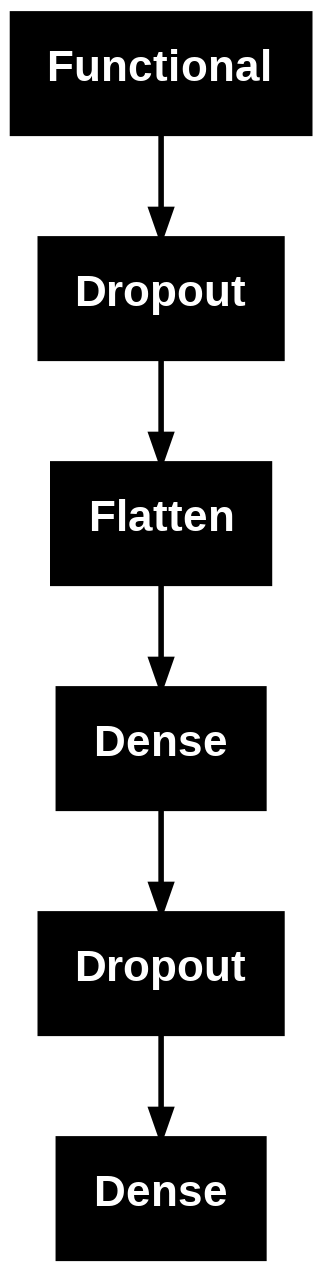

In [27]:
tf.keras.utils.plot_model(model_res)

In [28]:
# RESNET-50
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=6,
    verbose=1,
    mode='min',
    min_lr=5e-5
)

callbacks = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)

train_steps = train_generator.samples
val_steps = val_generator.samples
epoch = 100

model_res.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_res.fit(
    train_generator,
    steps_per_epoch=train_steps // BATCH_SIZE,
    epochs=epoch,
    validation_data=val_generator,
    validation_steps=val_steps // BATCH_SIZE,
    callbacks=[lr_reduce, callbacks],
    verbose=1,
)

# Showing best results
best_val_accuracy = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])

best_train_accuracy = max(history.history['accuracy'])
best_train_loss = min(history.history['loss'])

print(f"Best val_acc: {best_val_accuracy:.4f}")
print(f"Best val_loss: {best_val_loss:.4f}")
print(f"Best train_acc: {best_train_accuracy:.4f}")
print(f"Best train_loss: {best_train_loss:.4f}")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 101s 474ms/step - accuracy: 0.5185 - loss: 4.1253 - val_accuracy: 0.2428 - val_loss: 1.3281 - learning_rate: 0.0010
Epoch 2/100
 1/90 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.7500 - loss: 1.0222

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7500 - loss: 1.0222 - val_accuracy: 0.0000e+00 - val_loss: 2.1217 - learning_rate: 0.0010
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.6678 - loss: 0.8747 - val_accuracy: 0.2428 - val_loss: 1.5373 - learning_rate: 0.0010
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.5000 - loss: 1.5613 - val_accuracy: 0.0000e+00 - val_loss: 2.1271 - learning_rate: 0.0010
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.7412 - loss: 0.8409 - val_accuracy: 0.2596 - val_loss: 1.1053 - learning_rate: 0.0010
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.8750 - loss: 0.4010 - val_accuracy: 0.0000e+00 - val_loss: 1.1415 - learning_rate: 0.0010
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.6966 - loss: 0.8917 - val_accuracy: 0.2428 - val_loss: 1.8398 - learning_rate: 0.0010
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - loss: 0.

# EVALUATION

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
# RESNET50
Y_pred = model_res.predict(val_generator, val_steps // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cf_mtx = confusion_matrix(val_generator.classes, y_pred)
print(cf_mtx)

print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(val_generator.classes, y_pred,
                            target_names=target_names))

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step
Confusion Matrix
[[138  15  13]
 [ 10  85   6]
 [ 17  20 121]]
Classification Report
              precision    recall  f1-score   support

   Abrasions       0.84      0.83      0.83       166
     Bruises       0.71      0.84      0.77       101
       Burns       0.86      0.77      0.81       158

    accuracy                           0.81       425
   macro avg       0.80      0.81      0.81       425
weighted avg       0.82      0.81      0.81       425



# Plot False Detection

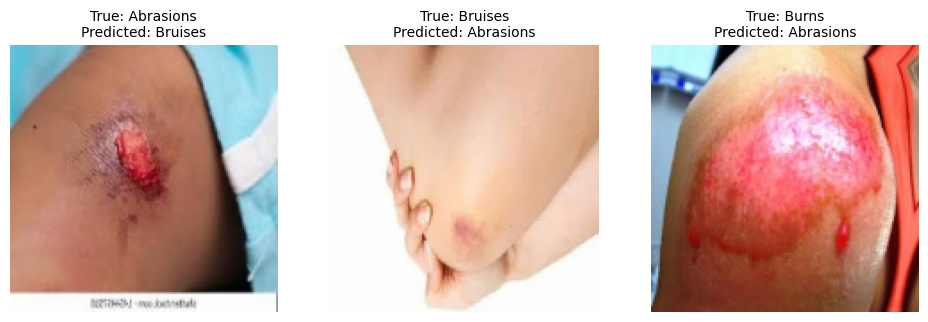

In [30]:
classes_with_errors_num = 5

# Sizing
img_ns = (150, 150)  # Define image size here

# Plotting
plt.figure(figsize=(20, 4))

class_indices_with_errors = []  # List to store class indices with errors

# Find all incorrect indices.
incorrect_indices = np.where(val_generator.classes != y_pred)[0]

# Loop through each class
for class_ind in range(len(target_names)):
    # Filter incorrect indices for the current class
    incorrect_indices_for_class = np.intersect1d(
        np.where(val_generator.classes == class_ind),
        incorrect_indices
    )

    if len(incorrect_indices_for_class) > 0:
        class_indices_with_errors.append(class_ind)

# Loop through classes with errors
for i in range(min(classes_with_errors_num, len(class_indices_with_errors))):
    class_ind = class_indices_with_errors[i]

    # Filter incorrect indices for the current class
    incorrect_indices_for_class = np.intersect1d(
        np.where(val_generator.classes == class_ind),
        incorrect_indices
    )

    index = incorrect_indices_for_class[0]  # Select the first error for this class

    true_class = val_generator.classes[index]
    predicted_class = y_pred[index]

    # Loading incorrect prediction images using PIL
    img_path = val_generator.filepaths[index]
    img = Image.open(img_path)

    # Sizing
    img = img.resize(img_ns)

    # Subplotting
    plt.subplot(1, classes_with_errors_num, i + 1)
    plt.imshow(img)

    plt.title(f"True: {target_names[true_class]}\nPredicted: {target_names[predicted_class]}", fontsize=10)
    plt.axis('off')

# Showing results
plt.show()

# Creating DataFrame and Heatmap

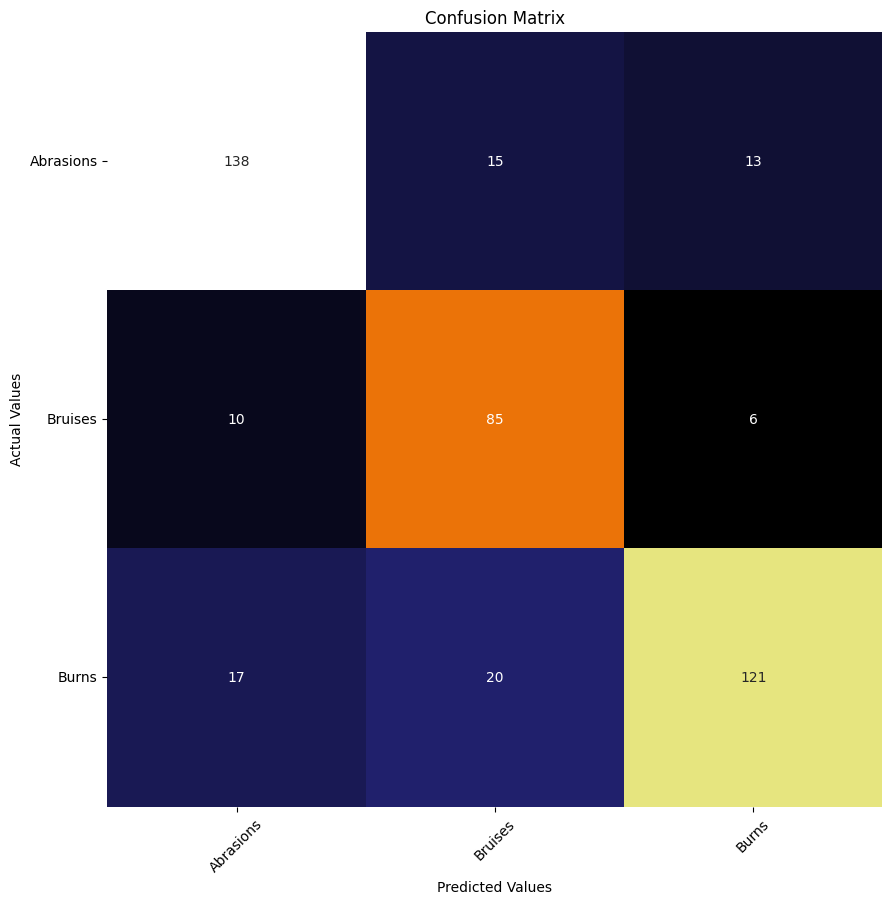

In [31]:
# --- RESNET-50 ---
# Creating DataFrame and Heatmap
import seaborn as sns
import pandas as pd

cm_df = pd.DataFrame(cf_mtx, index=target_names, columns=target_names)
plt.figure(figsize=(10, 15))  # Ubah ukuran gambar agar lebih tinggi daripada lebarnya

# Using axis orientation
sns.heatmap(cm_df, annot=True, cmap='CMRmap', fmt='d', cbar=False,
            square=True,
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')

plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()

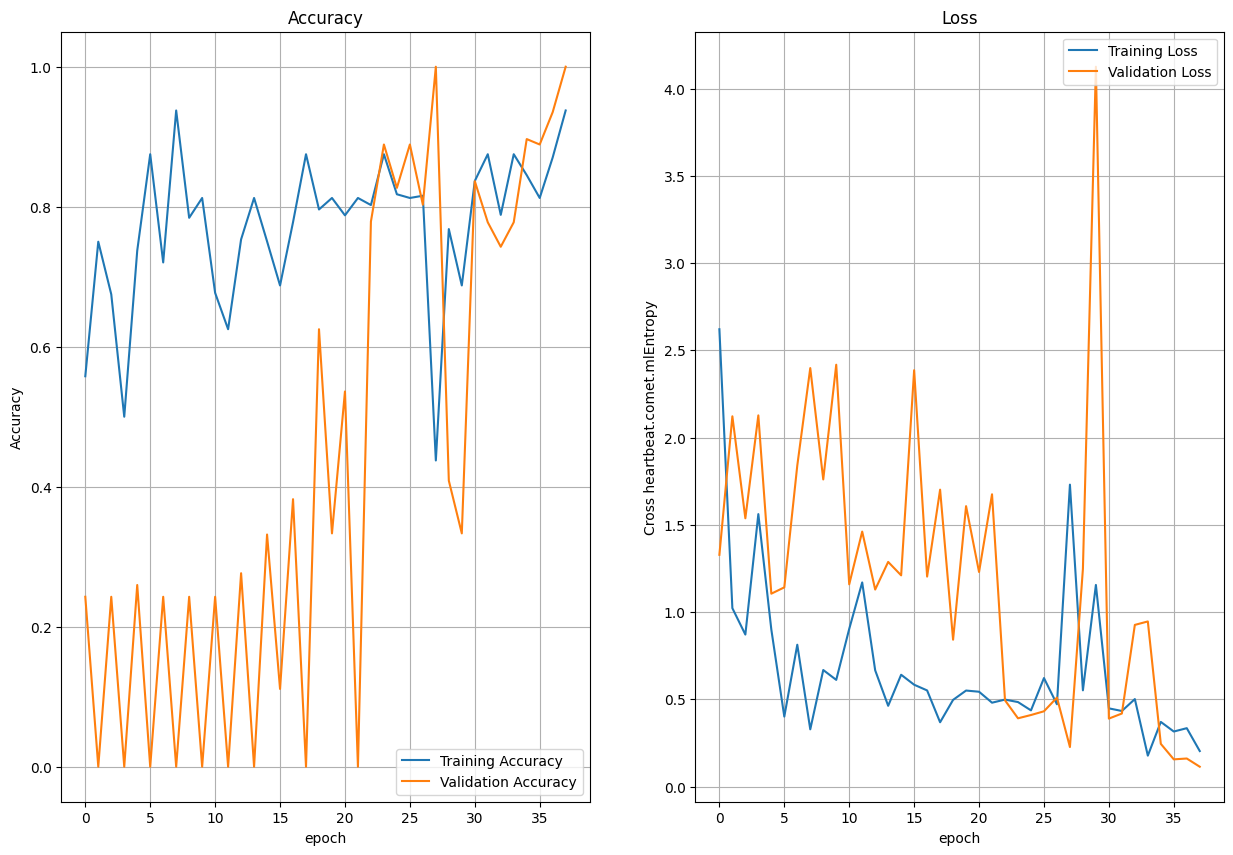

In [32]:
# RESNET-50
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.grid()
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.ylabel('Cross heartbeat.comet.mlEntropy')
plt.grid()
plt.title('Loss')
plt.xlabel('epoch')

plt.show()

In [33]:
model_res.save('/content/model_Resnet50.h5')

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_res)
tflite_model = converter.convert()

with tf.io.gfile.GFile('/content/model_Resnet50.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp1fi7_exb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_175')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132090722589280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132090722663440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132090722853008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132090722854768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132090722852128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132090722853536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132090722903392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132090722895824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132090722903568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132090722905328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1320907229